<a href="https://colab.research.google.com/github/rishi-latchmepersad/TinyML-Home-Weather-Forecasting/blob/main/machine_learning/rnn/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rishi-latchmepersad/TinyML-Home-Weather-Forecasting/blob/main/machine_learning/rnn/model_training.ipynb)

In [161]:
import pandas as pd
from pathlib import Path

# Import Data
We need to concatenate all readings from all csvs into a single DataFrame.

In [162]:
csv_files = list(Path('/content/measurements/').glob('*.csv'))
dfs = []

for csv_file in csv_files:
    df_temp = pd.read_csv(csv_file)
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)
print(f"Successfully loaded and concatenated {len(csv_files)} CSV files into a single DataFrame.")
print(f"The final DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Successfully loaded and concatenated 48 CSV files into a single DataFrame.
The final DataFrame has 1780778 rows and 5 columns.


,timestamp_iso8601,sensor,quantity,value,unit
0,2025-10-01T00:00:34Z,bme280,temperature_c,27.908127,degC
1,2025-10-01T00:00:34Z,bme280,pressure_pa,101142.351562,Pa
2,2025-10-01T00:00:34Z,bme280,humidity_pct,74.104507,pct
3,2025-10-01T00:00:34Z,lm393,is_raining,0.000000,NaN
4,2025-10-01T00:00:34Z,veml7700,lux_lx,0.000000,lx


In [163]:
df = df[["timestamp_iso8601", "quantity", "value"]]
df.head()

,timestamp_iso8601,quantity,value
0,2025-10-01T00:00:34Z,temperature_c,27.908127
1,2025-10-01T00:00:34Z,pressure_pa,101142.351562
2,2025-10-01T00:00:34Z,humidity_pct,74.104507
3,2025-10-01T00:00:34Z,is_raining,0.000000
4,2025-10-01T00:00:34Z,lux_lx,0.000000


# Data Pre-Processing

## Pivoting - Reformating the data into multiple columns
We make each quantity (measurement type e.g. lux, pressure, temperature) its own column, so each row will have one value per quantity instead of one row per quantity.

In [164]:
df["quantity"].value_counts()

,count
quantity,
lux_lx,358849
is_raining,358586
temperature_c,354560
pressure_pa,354560
humidity_pct,354223


In [165]:
df = df.pivot_table(values='value', index='timestamp_iso8601',
                       columns='quantity', aggfunc="mean").reset_index()
print(df.columns.name)
df.head()

quantity


quantity,timestamp_iso8601,humidity_pct,is_raining,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,0.0,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,0.0,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,NaN,100961.906250,28.982277


In [166]:
df.columns.name = None

In [167]:
df = df.drop(["is_raining"], axis=1)
df.head()

,timestamp_iso8601,humidity_pct,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,100961.906250,28.982277


In [168]:
len(df)

1022998

In [169]:
df.head()

,timestamp_iso8601,humidity_pct,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,100961.906250,28.982277


In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022998 entries, 0 to 1022997
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   timestamp_iso8601  1022998 non-null  object 
 1   humidity_pct       354108 non-null   float64
 2   lux_lx             358755 non-null   float64
 3   pressure_pa        354446 non-null   float64
 4   temperature_c      354466 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.0+ MB


## Resampling - Handling small gaps between sensor readings
Each quantity is captured by a different sensor. Since the data is captured every 10 seconds, there may be very slight differences (seconds or milliseconds) between when each sensor actually captures its information. This results in readings that represent the same 10 second period appear as different rows. In reality, they should represent the same instance. **Resampling** organizes the data into 30 minute chunks, and takes the average of each value within that 30 minute chunk, thus consolidating them into a single row.

In [171]:
df["timestamp_iso8601"] = pd.to_datetime(df["timestamp_iso8601"], format='mixed')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022998 entries, 0 to 1022997
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   timestamp_iso8601  1022998 non-null  datetime64[ns, UTC]
 1   humidity_pct       354108 non-null   float64            
 2   lux_lx             358755 non-null   float64            
 3   pressure_pa        354446 non-null   float64            
 4   temperature_c      354466 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 39.0 MB


In [172]:
# In the original dataset, the sensor readings may have come in at very slightly
# different times, i.e. 1 second apart. But each of these should have technically
# been one instance. So we resample, to get the average of each value within the
# specified resample time.

df = df.set_index("timestamp_iso8601").resample('30min').mean()
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615


In [173]:
len(df)

2251

In [174]:
df = df.sort_values("timestamp_iso8601")
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615


## Interpolation - Handling gaps in the continuous time data
After resampling, there would have been periods where the board was turned off. This results in gaps in the data. Interpolation uses the nearest values to the missing times to fill them.

In [175]:
df.loc["2025-09-04 22:00:00+00:00":"2025-09-05 00:00:00+00:00"]

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615


In [176]:
print(f"Data ranges from {df.index[0]} to {df.index[-1]} and we have {len(df)} instances")

Data ranges from 2025-09-04 22:00:00+00:00 to 2025-10-21 19:00:00+00:00 and we have 2251 instances


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2251 entries, 2025-09-04 22:00:00+00:00 to 2025-10-21 19:00:00+00:00
Freq: 30min
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   humidity_pct   2205 non-null   float64
 1   lux_lx         2204 non-null   float64
 2   pressure_pa    2205 non-null   float64
 3   temperature_c  2205 non-null   float64
dtypes: float64(4)
memory usage: 152.5 KB


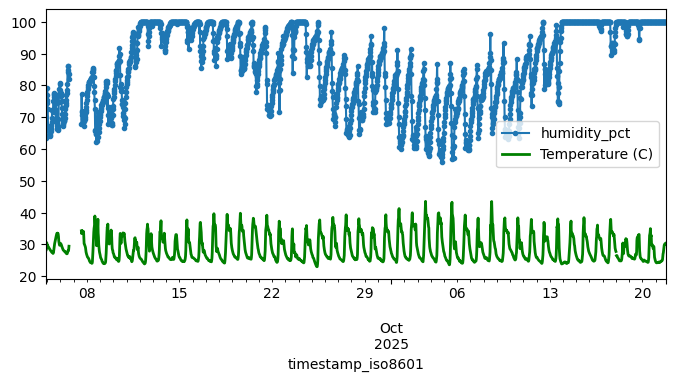

In [178]:
# Plotting
import matplotlib.pyplot as plt

# The last 5-day period
ax = df["humidity_pct"].plot(grid=True, marker='.', figsize=(8, 3.5))

df["temperature_c"].plot(
    ax=ax, color='green', linewidth=2, label="Temperature (C)"
)

# Add a legend to distinguish them
ax.legend()

In [179]:
# The gaps indicate times the board was off

In [180]:
df = df.interpolate(method="linear")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2251 entries, 2025-09-04 22:00:00+00:00 to 2025-10-21 19:00:00+00:00
Freq: 30min
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   humidity_pct   2251 non-null   float64
 1   lux_lx         2251 non-null   float64
 2   pressure_pa    2251 non-null   float64
 3   temperature_c  2251 non-null   float64
dtypes: float64(4)
memory usage: 152.5 KB


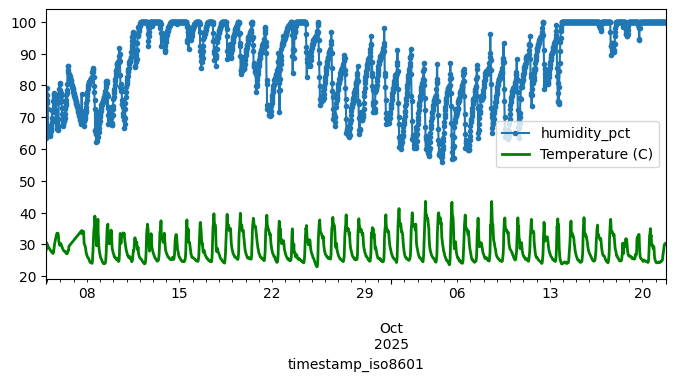

In [181]:
# The last 5-day period
ax = df["humidity_pct"].plot(grid=True, marker='.', figsize=(8, 3.5))

df["temperature_c"].plot(
    ax=ax, color='green', linewidth=2, label="Temperature (C)"
)
# Add a legend to distinguish them
ax.legend()

# Feature Engineering
We include the following features:
1. `sine_hour` - This captures the cyclical nature of the hour of the day. e.g. when taking the sine of the hour of the day, 23:00 is closer to 00:00 as it should be.
2. `cos_hour` - Similar to the above.
3. `temperature_delta` -  The difference between the temperature at the current timestamp and the timestamp immediately before.
4. `temp_mean_6h` - The average temperature over the past 6 hours at this current timestamp.
5. `temp_humidity_6h` - The average humidity over the past 6 hours at this current timestamp.

In [182]:
hour_of_day = df.index.hour
hour_of_day

Index([22, 22, 23, 23,  0,  0,  1,  1,  2,  2,
       ...
       14, 15, 15, 16, 16, 17, 17, 18, 18, 19],
      dtype='int32', name='timestamp_iso8601', length=2251)

In [183]:
import numpy as np

df["sine_hour"] = np.sin(2 * np.pi * hour_of_day / 24)
df["cos_hour"] = np.cos(2 * np.pi * hour_of_day / 24)
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour
timestamp_iso8601,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000


In [184]:
df["delta_temperature"] = df["temperature_c"] - df["temperature_c"].shift(1)
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature
timestamp_iso8601,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025,NaN
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025,0.174832
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926,2.232628
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926,-0.260587
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000,-0.584741


In [185]:
# Since the first row will be null, we fill it with the mean for this column
df['delta_temperature'].fillna(df['delta_temperature'].mean(), inplace=True)
df.head()

/tmp/ipython-input-1216042316.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['delta_temperature'].fillna(df['delta_temperature'].mean(), inplace=True)


,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature
timestamp_iso8601,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025,0.000968
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025,0.174832
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926,2.232628
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926,-0.260587
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000,-0.584741


In [186]:
df["temp_mean_6h"] = df["temperature_c"].rolling(window=12, min_periods=1).mean()
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h
timestamp_iso8601,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025,0.000968,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025,0.174832,28.259899
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926,2.232628,29.033247
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926,-0.260587,29.354774
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000,-0.584741,29.430743


In [187]:
df["humidity_mean_6h"] = df["humidity_pct"].rolling(window=12, min_periods=1).mean()
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
timestamp_iso8601,,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025,0.000968,28.172483,63.341935
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025,0.174832,28.259899,66.644727
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926,2.232628,29.033247,69.562658
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926,-0.260587,29.354774,71.393847
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000,-0.584741,29.430743,72.973036


## Normalizing

In [188]:
df.describe()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
count,2251.000000,2251.000000,2251.000000,2251.000000,2.251000e+03,2.251000e+03,2251.000000,2251.000000,2251.000000
mean,86.075111,4456.782739,101062.984829,28.882355,1.826828e-03,-1.187487e-03,0.000968,28.879972,86.000806
std,12.293825,6760.656839,167.271825,4.098369,7.069683e-01,7.075560e-01,1.003573,3.442058,11.864258
min,55.900582,0.000000,100635.793644,22.989888,-1.000000e+00,-1.000000e+00,-4.365562,23.692777,58.277823
25%,75.994236,0.000000,100940.903754,25.460715,-7.071068e-01,-7.071068e-01,-0.319517,25.784417,76.001434
50%,87.413169,94.088907,101061.558714,27.478218,1.224647e-16,-1.836970e-16,-0.108394,28.169648,86.737498
75%,99.440533,7028.690959,101180.300570,32.099490,7.071068e-01,7.071068e-01,0.128898,31.584787,98.495679
max,100.000000,28891.834070,101492.141722,43.539995,1.000000e+00,1.000000e+00,4.937021,39.408742,100.000000


In [189]:
from sklearn.preprocessing import StandardScaler

# Only scale the feature columns so the model learns the real temperature scale
feature_cols = [col for col in df.select_dtypes(include='number').columns if col != "temperature_c"]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [190]:
df.describe()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
count,2.251000e+03,2.251000e+03,2.251000e+03,2251.000000,2.251000e+03,2.251000e+03,2.251000e+03,2.251000e+03,2.251000e+03
mean,3.409090e-16,-1.010101e-16,-8.106058e-15,28.882355,1.736111e-17,1.736111e-17,9.864265e-18,-6.439392e-16,2.020201e-16
std,1.000222e+00,1.000222e+00,1.000222e+00,4.098369,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00
min,-2.454991e+00,-6.593698e-01,-2.554442e+00,22.989888,-1.417389e+00,-1.411951e+00,-4.351953e+00,-1.507339e+00,-2.337200e+00
25%,-8.201772e-01,-6.593698e-01,-7.299986e-01,25.460715,-1.003003e+00,-9.979085e-01,-3.194157e-01,-8.995324e-01,-8.430020e-01
50%,1.088640e-01,-6.454496e-01,-8.527633e-03,27.478218,-2.584605e-03,1.678667e-03,-1.089975e-01,-2.064119e-01,6.210721e-02
75%,1.087407e+00,3.805074e-01,7.015037e-01,32.099490,9.978335e-01,1.001266e+00,1.275027e-01,7.859879e-01,1.053387e+00
max,1.132925e+00,3.615104e+00,2.566196e+00,43.539995,1.412220e+00,1.415308e+00,4.919574e+00,3.059539e+00,1.180209e+00


# Creating the Datasets used by the Model

## Define Input Window Size and Prediction Window Size
We want to use the previous 24 hours of data to predict the next 12 hours of temperatures.

In [191]:
sample_size_in_hrs = 0.5 # we resampled to 30-min chunks
window_size_in_hrs = 24

# since each instance is a 30-min period, and we want a 24hr window
seq_length = int(window_size_in_hrs / sample_size_in_hrs)

## Train, Test Split
We use 80% of the data to train. Then the remaining 20% is then split into equal 10% segments. **No shuffling is done as the time series data needs to stay in chronological order**.

In [192]:
from sklearn.model_selection import train_test_split

# First split: 80% and 20%
df_train, df_temp = train_test_split(df, test_size=0.2,
                                     random_state=42, shuffle=False)

# Second split: split the remaining 20% into two 10% parts
df_valid, df_test = train_test_split(df_temp, test_size=0.5,
                                     random_state=42, shuffle=False)

print(f"Train: {len(df_train)}")
print(f"Valid: {len(df_valid)}")
print(f"Test: {len(df_test)}")


Train: 1800
Valid: 225
Test: 226


In [193]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1800 entries, 2025-09-04 22:00:00+00:00 to 2025-10-12 09:30:00+00:00
Freq: 30min
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   humidity_pct       1800 non-null   float64
 1   lux_lx             1800 non-null   float64
 2   pressure_pa        1800 non-null   float64
 3   temperature_c      1800 non-null   float64
 4   sine_hour          1800 non-null   float64
 5   cos_hour           1800 non-null   float64
 6   delta_temperature  1800 non-null   float64
 7   temp_mean_6h       1800 non-null   float64
 8   humidity_mean_6h   1800 non-null   float64
dtypes: float64(9)
memory usage: 140.6 KB


In [194]:
df_train.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
timestamp_iso8601,,,,,,,,,
2025-09-04 22:00:00+00:00,-1.849565,-0.655435,-0.534381,28.172483,-0.709987,1.225918,0.000000,-0.205588,-1.910267
2025-09-04 22:30:00+00:00,-1.312136,-0.653129,-0.558529,28.347315,-0.709987,1.225918,0.173283,-0.180186,-1.631824
2025-09-04 23:00:00+00:00,-0.868645,-0.644958,-0.534775,30.579943,-0.368763,1.367140,2.224210,0.044540,-1.385826
2025-09-04 23:30:00+00:00,-0.747509,-0.644901,-0.325886,30.319356,-0.368763,1.367140,-0.260682,0.137972,-1.231447
2025-09-05 00:00:00+00:00,-0.552051,-0.644897,-0.219706,29.734615,-0.002585,1.415308,-0.583754,0.160048,-1.098313


## Converting DataFrames to Timeseries Datasets

In [195]:
import tensorflow as tf

In [196]:
def split_inputs_and_targets(
    multivariable_series,
    ahead=24, # the next 24 30-minute time slots (12 hours)
    target_col=3):
  return multivariable_series[:, :-ahead], multivariable_series[:, -ahead:, target_col]

In [197]:
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 24,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

In [198]:
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 24,
    batch_size=32
).map(split_inputs_and_targets)
valid_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

# Build and Compile the Model

## I Should Use Keras Tuner here once i get the base model to run

## Definition

In [199]:
num_features = df_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, num_features)),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(24)
])

In [200]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=15,
    restore_best_weights=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [201]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

## Training

In [202]:
history = model.fit(
    train_ds, validation_data=valid_ds,
    epochs=500, callbacks=[early_stopping_cb]
)

Epoch 1/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 26.1584 - mae: 26.6584 - val_loss: 12.2074 - val_mae: 12.7029
Epoch 2/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 8.2670 - mae: 8.7558 - val_loss: 2.9549 - val_mae: 3.4309
Epoch 3/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.0564 - mae: 3.5313 - val_loss: 2.9062 - val_mae: 3.3825
Epoch 4/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.0360 - mae: 3.5113 - val_loss: 2.8337 - val_mae: 3.3064
Epoch 5/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8126 - mae: 3.2756 - val_loss: 2.2070 - val_mae: 2.6730
Epoch 6/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.2627 - mae: 2.7051 - val_loss: 2.1118 - val_mae: 2.5585
Epoch 7/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 2.1809 - mae: 2.6118 - val_loss: 2.0744 - val_mae: 2.5152
Epoch 8/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.1098 - mae: 2.5403 - val_loss: 2.0436 - val_mae: 2.4823
Epoch 9/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step 

# Using the Model to Make Predictions

In [203]:
def predict_12_hours(model, input_df, seq_length, start_idx, target_col_name,
                     window_size_in_hrs):
  X = input_df.to_numpy()[np.newaxis, start_idx:start_idx+seq_length]
  print(f"Shape of Input Data: {X.shape}")

  Y_pred = model.predict(X)[0]
  print(f"Model Prediction: {Y_pred}")

  actual_next_12_hrs = input_df[start_idx+seq_length:
                                start_idx+seq_length+window_size_in_hrs][target_col_name].to_numpy()
  print(f"Actual Next 12 Hours: {actual_next_12_hrs}")

  for i in range(window_size_in_hrs):
    model_pred_in_deg = Y_pred[i]
    actual_in_deg = actual_next_12_hrs[i]
    pred_error = model_pred_in_deg - actual_in_deg

    print(f"{(i+1) * 30} MINUTES INTO THE FUTURE!")
    print(f"Model Prediction: {model_pred_in_deg} degrees celcius.")
    print(f"Actual Value: {actual_in_deg} degrees celcius.")
    print(f"Prediction Error: {pred_error} degrees celcius.")
    print('*'*20)

  return Y_pred, actual_next_12_hrs

In [204]:
Y_pred_deg, actual_val_deg = predict_12_hours(
    model, df_valid, seq_length, 0, "temperature_c",
    window_size_in_hrs
)

Shape of Input Data: (1, 48, 9)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Model Prediction: [23.975641 24.565708 25.606348 27.182056 29.25384  31.54454  33.252987
 35.202644 36.60402  37.27261  36.96951  36.44073  35.3265   34.22947
 33.15507  32.241005 31.175304 30.187395 30.119118 30.135597 29.730747
 29.625523 28.938341 28.904793]
Actual Next 12 Hours: [24.65692772 25.01264446 25.52419686 26.54715869 28.64425348 32.92339755
 35.57774908 35.27805456 37.31125931 38.03783017 36.2268941  36.32646966
 35.55347094 31.49198354 29.0004531  27.39269205 26.33203901 25.44285491
 25.10318853 24.69323829 24.46773361 24.33027607 24.00600544 23.87526834]
30 MINUTES INTO THE FUTURE!
Model Prediction: 23.97564125061035 degrees celcius.
Actual Value: 24.656927717105262 degrees celcius.
Prediction Error: -0.6812864664949103 degrees celcius.
********************
60 MINUTES INTO THE FUTURE!
Model Prediction: 24.56570816040039 degrees celcius.
Actual Value: 25.01264445731707 degrees celcius.
Prediction Erro

# Evaluating the model on the test set

In [205]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226 entries, 2025-10-17 02:30:00+00:00 to 2025-10-21 19:00:00+00:00
Freq: 30min
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   humidity_pct       226 non-null    float64
 1   lux_lx             226 non-null    float64
 2   pressure_pa        226 non-null    float64
 3   temperature_c      226 non-null    float64
 4   sine_hour          226 non-null    float64
 5   cos_hour           226 non-null    float64
 6   delta_temperature  226 non-null    float64
 7   temp_mean_6h       226 non-null    float64
 8   humidity_mean_6h   226 non-null    float64
dtypes: float64(9)
memory usage: 17.7 KB


In [206]:
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_test.to_numpy(),
    targets=None,
    sequence_length=seq_length + 24,  # same as in training
    batch_size=32
).map(split_inputs_and_targets)


In [207]:
results = model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3674 - mae: 1.7844


In [208]:
test_mae = results[1]
test_mae

1.6325058937072754

In [209]:
test_mae_deg = test_mae
print(f"Test MAE Degrees Celcius: {test_mae_deg}")

Test MAE Degrees Celcius: 1.6325058937072754


# Preparing the Model for Deployment on the Embedded Board

## Quantizing, Pruning and Saving the TFLite Model

In [210]:
def representative_dataset():
    for batch in tf.keras.utils.timeseries_dataset_from_array(
        data=df_train.to_numpy().astype(np.float32),
        targets=None,
        sequence_length=seq_length,
        batch_size=1,
    ).take(200):
        yield [batch]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
# Allow TFLite built-in ops and fallback to selected TensorFlow ops for unsupported operations.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Remove the experimental flag, as it might conflict with dynamic range quantization.
# converter._experimental_lower_tensor_list_ops = False

# Remove strict inference_input_type and inference_output_type = tf.int8
# to enable dynamic range quantization, which is more forgiving for RNNs
# that might contain ops not fully supported by full integer quantization.
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

quantized_model = converter.convert()
with open("quantized_rnn_model.tflite", "wb") as f:
    f.write(quantized_model)


Saved artifact at '/tmp/tmpft_pijl7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  138254390346192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138254390349264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138254390347536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138254390349456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138254390349840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138254390348496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138254390350032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138254390347728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138254390348112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138254390348304: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


ConverterError: <unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "sequential_3_1/simple_rnn_6_1/TensorArrayV2_1@__inference_function_220848"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_220899"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "sequential_3_1/simple_rnn_6_1/TensorArrayV2_1@__inference_function_220848"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_220899"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


## Reload the TFLite Model

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="quantized_rnn_model.tflite")
interpreter.allocate_tensors()

# Get input and output details (optional)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Model loaded successfully!")
print("Input details:", input_details)
print("Output details:", output_details)

In [ ]:

# Evaluating the size of the tflite model
import os

file_path = "quantized_rnn_model.tflite"
size_in_bytes = os.path.getsize(file_path)
size_in_kb = size_in_bytes / 1024
size_in_mb = size_in_kb / 1024

print(f"Model size: {size_in_bytes} bytes ({size_in_kb:.2f} KB / {size_in_mb:.2f} MB)")


## Using the TFLite Model to Make a Prediction

In [ ]:
import numpy as np

# Prepare input (same as Keras)
# input_scale, input_zero_point = input_details[0]["quantization"]
# output_scale, output_zero_point = output_details[0]["quantization"]

# These functions are no longer needed for dynamic range quantization
# def quantize_input(window: np.ndarray) -> np.ndarray:
#     return np.clip(np.round(window / input_scale + input_zero_point), -128, 127).astype(np.int8)

# def dequantize_output(tensor: np.ndarray) -> np.ndarray:
#     return (tensor.astype(np.float32) - output_zero_point) * output_scale

X = df_valid.to_numpy()[np.newaxis, :seq_length].astype(np.float32)  # shape: (1, seq_length, features)
# X_int8 = quantize_input(X) # No need to quantize input manually

# Set input tensor
interpreter.set_tensor(input_details[0]["index"], X) # Pass float32 input directly

# Run inference
interpreter.invoke()

# Get prediction
output_data = interpreter.get_tensor(output_details[0]["index"]) # Output is already float32
# output_data = dequantize_output(output_data_int8) # No need to dequantize output manually
print("Prediction:", output_data)


## Evaluating the TFLite Model on the Test Dataset

In [ ]:
import numpy as np

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

seq_length = 48  # or whatever your window size is
num_features = df_test.shape[1]

# Store predictions and true values
preds = []
trues = []

for start in range(len(df_test) - seq_length - 24 + 1):  # 24 is your prediction horizon
    X = df_test.to_numpy()[start:start+seq_length].astype(np.float32)
    # X_int8 = quantize_input(X[np.newaxis, ...])  # No longer needed
    interpreter.set_tensor(input_details[0]['index'], X[np.newaxis, ...]) # Pass float32 input directly
    interpreter.invoke()
    y_pred = interpreter.get_tensor(output_details[0]['index'])[0] # Output is already float32
    # y_pred = dequantize_output(y_pred_int8) # No longer needed
    preds.append(y_pred)
    # True values for the next 24 steps of the target column (e.g., temperature)
    y_true = df_test.iloc[start+seq_length:start+seq_length+24]['temperature_c'].to_numpy()
    trues.append(y_true)


In [ ]:
preds = np.array(preds)
trues = np.array(trues)

# Temperature targets are kept in their original scale, so predictions are already in Celsius
mae = np.mean(np.abs(preds - trues))


In [ ]:
print(f"TFLite Model Test MAE: {mae}")
print(f"TFLite Model Test MAE Degrees Celcius: {mae}")